# Discrete Inverse Transform Sampling Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/carsten-j/mc-lab/blob/main/notebooks/discrete_inverse_transform_demo.ipynb)

This notebook demonstrates the discrete inverse transform sampling method implemented in the `mc-lab-edu` package, focusing on the algorithm for discrete distributions with step function CDFs.

In [69]:
# Check if mc-lab-edu is installed, install if not
import importlib.util

# Check if mc_lab package is available
spec = importlib.util.find_spec("mc_lab")

if spec is None:
    print("📦 Installing mc-lab-edu...")
    !pip install mc-lab-edu
    print("✅ mc-lab-edu has been installed successfully!")
else:
    print("✅ mc-lab-edu is already installed")

print("🎉 Ready to use mc-lab!")

✅ mc-lab-edu is already installed
🎉 Ready to use mc-lab!


# Discrete Inverse Transform Method: Theory and Implementation

This notebook demonstrates the discrete inverse transform method, which extends the fundamental inverse transform theorem to discrete distributions with step function CDFs.

In [70]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from mc_lab._rng import as_generator
from mc_lab.inverse_transform import (
    DiscreteInverseTransformSampler,
    create_sampler,
)

# Set style for consistent plots
plt.style.use("seaborn-v0_8-dark")
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 11

# Color palette following project guidelines
COLORS = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499"]

# Fixed random seed for reproducibility
RANDOM_SEED = 42
rng = as_generator(RANDOM_SEED)

## 1. Theoretical Foundation: Discrete Distributions

### Algorithm 2.3: Discrete Inverse Transform Method

For discrete random variables that take values $x_1, x_2, \ldots$ with probabilities $p_1, p_2, \ldots$:

1. **Generate** $U \sim \mathcal{U}(0,1)$
2. **Find** the smallest positive integer $k$ such that $F(x_k) \geq U$
3. **Return** $X = x_k$

### Key Differences from Continuous Case

**Step Function CDF**: Unlike continuous distributions, discrete CDFs are step functions with:
- **Jumps** at each possible value $x_k$
- **Flat segments** between values
- **Right-continuous** behavior at jump points

**Generalized Inverse**: The inverse CDF is defined as:
$$F^{-1}(u) = \min\{x : F(x) \geq u\}$$

This ensures we always find the correct discrete value corresponding to each uniform input.

### Implementation Strategy

**Efficient Search**: We use `np.searchsorted()` to efficiently find the correct discrete value:
- Pre-compute cumulative probabilities: $F(x_k) = \sum_{i=1}^k p_i$
- For each uniform $u$, find the first $k$ where $F(x_k) \geq u$
- Return the corresponding discrete value $x_k$

**Why This Works**: The step function property ensures that if $F(x_k) \geq u$, then $x_k$ is the correct inverse transform result.

## 2. Visual Demonstration: Step Function Transformation

In [71]:
def visualize_discrete_inverse_transform(
    values, probabilities, dist_name, n_samples=100
):
    """
    Create step-by-step visualization of discrete inverse transform process.

    Parameters
    ----------
    values : array-like
        Discrete values the random variable can take
    probabilities : array-like
        Probability of each value
    dist_name : str
        Name of the distribution for titles
    n_samples : int
        Number of samples to generate and visualize
    """
    # Create sampler
    sampler = DiscreteInverseTransformSampler(
        values, probabilities, random_state=RANDOM_SEED
    )

    # Generate uniform samples
    u_samples = rng.uniform(0, 1, n_samples)

    # Transform using discrete inverse CDF
    x_samples = sampler._discrete_inverse_cdf(u_samples)

    # Compute cumulative probabilities for visualization
    cumulative_probs = np.cumsum(probabilities)

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Add overall title
    fig.suptitle(
        f"Discrete Inverse Transform Method: {dist_name}",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )
    fig.text(
        0.5,
        0.94,
        "Four-Step Process: (1) Generate Uniform → (2) Find F(x_k) ≥ U → (3) Return x_k → (4) Verify Distribution",
        ha="center",
        fontsize=12,
        style="italic",
        color="#444444",
    )

    # 1. Uniform samples histogram
    ax1.hist(u_samples, bins=20, alpha=0.7, color=COLORS[0], edgecolor="black")
    ax1.set_title("Step 1: Uniform Random Samples U ~ Uniform(0,1)")
    ax1.set_xlabel("u")
    ax1.set_ylabel("Frequency")
    ax1.grid(True, alpha=0.3)

    # 2. Step function CDF with transformation arrows
    # Create step function plot
    x_plot = []
    cdf_plot = []

    # Add initial point
    x_plot.extend([values[0] - 0.5, values[0]])
    cdf_plot.extend([0, 0])

    # Add steps
    for i, (val, cum_prob) in enumerate(zip(values, cumulative_probs)):
        # Vertical jump
        if i > 0:
            x_plot.append(val)
            cdf_plot.append(cumulative_probs[i - 1])

        x_plot.append(val)
        cdf_plot.append(cum_prob)

        # Horizontal line to next value
        if i < len(values) - 1:
            x_plot.append(values[i + 1])
            cdf_plot.append(cum_prob)

    # Extend final horizontal line
    x_plot.append(values[-1] + 0.5)
    cdf_plot.append(1.0)

    ax2.plot(x_plot, cdf_plot, color=COLORS[1], linewidth=2, label=f"{dist_name} CDF")

    # Add dots at jump points
    ax2.scatter(values, cumulative_probs, color=COLORS[1], s=50, zorder=5)

    # Show transformation for a few sample points
    sample_indices = np.linspace(0, len(u_samples) - 1, 6, dtype=int)
    for i in sample_indices:
        u_val = u_samples[i]
        x_val = x_samples[i]

        # Horizontal line from y-axis to CDF
        ax2.axhline(
            y=u_val,
            xmin=0,
            xmax=(x_val - values[0] + 0.5) / (values[-1] - values[0] + 1),
            color=COLORS[5],
            linestyle="--",
            alpha=0.6,
            linewidth=1,
        )
        # Vertical line from CDF to x-axis
        ax2.axvline(
            x=x_val,
            ymin=0,
            ymax=u_val,
            color=COLORS[5],
            linestyle="--",
            alpha=0.6,
            linewidth=1,
        )
        ax2.plot(x_val, u_val, "o", color=COLORS[5], markersize=6, alpha=0.8)

    ax2.set_title("Step 2: Step Function CDF and Inverse Mapping")
    ax2.set_xlabel("x")
    ax2.set_ylabel("F(x)")
    ax2.set_ylim(0, 1.05)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3. Bar plot of transformed samples
    unique_vals, counts = np.unique(x_samples, return_counts=True)
    frequencies = counts / n_samples

    ax3.bar(
        unique_vals,
        frequencies,
        alpha=0.7,
        color=COLORS[2],
        edgecolor="black",
        width=0.6,
    )
    ax3.set_title(f"Step 3: Samples from {dist_name} Distribution")
    ax3.set_xlabel("x")
    ax3.set_ylabel("Relative Frequency")
    ax3.grid(True, alpha=0.3)

    # 4. Comparison with theoretical probabilities
    # Plot theoretical probabilities
    ax4.bar(
        values - 0.2,
        probabilities,
        width=0.4,
        alpha=0.7,
        color=COLORS[6],
        edgecolor="black",
        label="Theoretical PMF",
    )

    # Plot observed frequencies
    observed_probs = np.zeros_like(values, dtype=float)
    for i, val in enumerate(values):
        mask = unique_vals == val
        if np.any(mask):
            observed_probs[i] = frequencies[mask][0]

    ax4.bar(
        values + 0.2,
        observed_probs,
        width=0.4,
        alpha=0.7,
        color=COLORS[2],
        edgecolor="black",
        label="Sample Frequencies",
    )

    ax4.set_title("Step 4: Verification Against Theoretical Distribution")
    ax4.set_xlabel("x")
    ax4.set_ylabel("Probability")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    return sampler

## 3. Example 1: Custom Discrete Distribution

We start with a simple custom discrete distribution to clearly illustrate the algorithm.

Custom Discrete Distribution:
Values: [ 1  3  5  7 10]
Probabilities: [0.1  0.3  0.4  0.15 0.05]
Sum of probabilities: 1.0


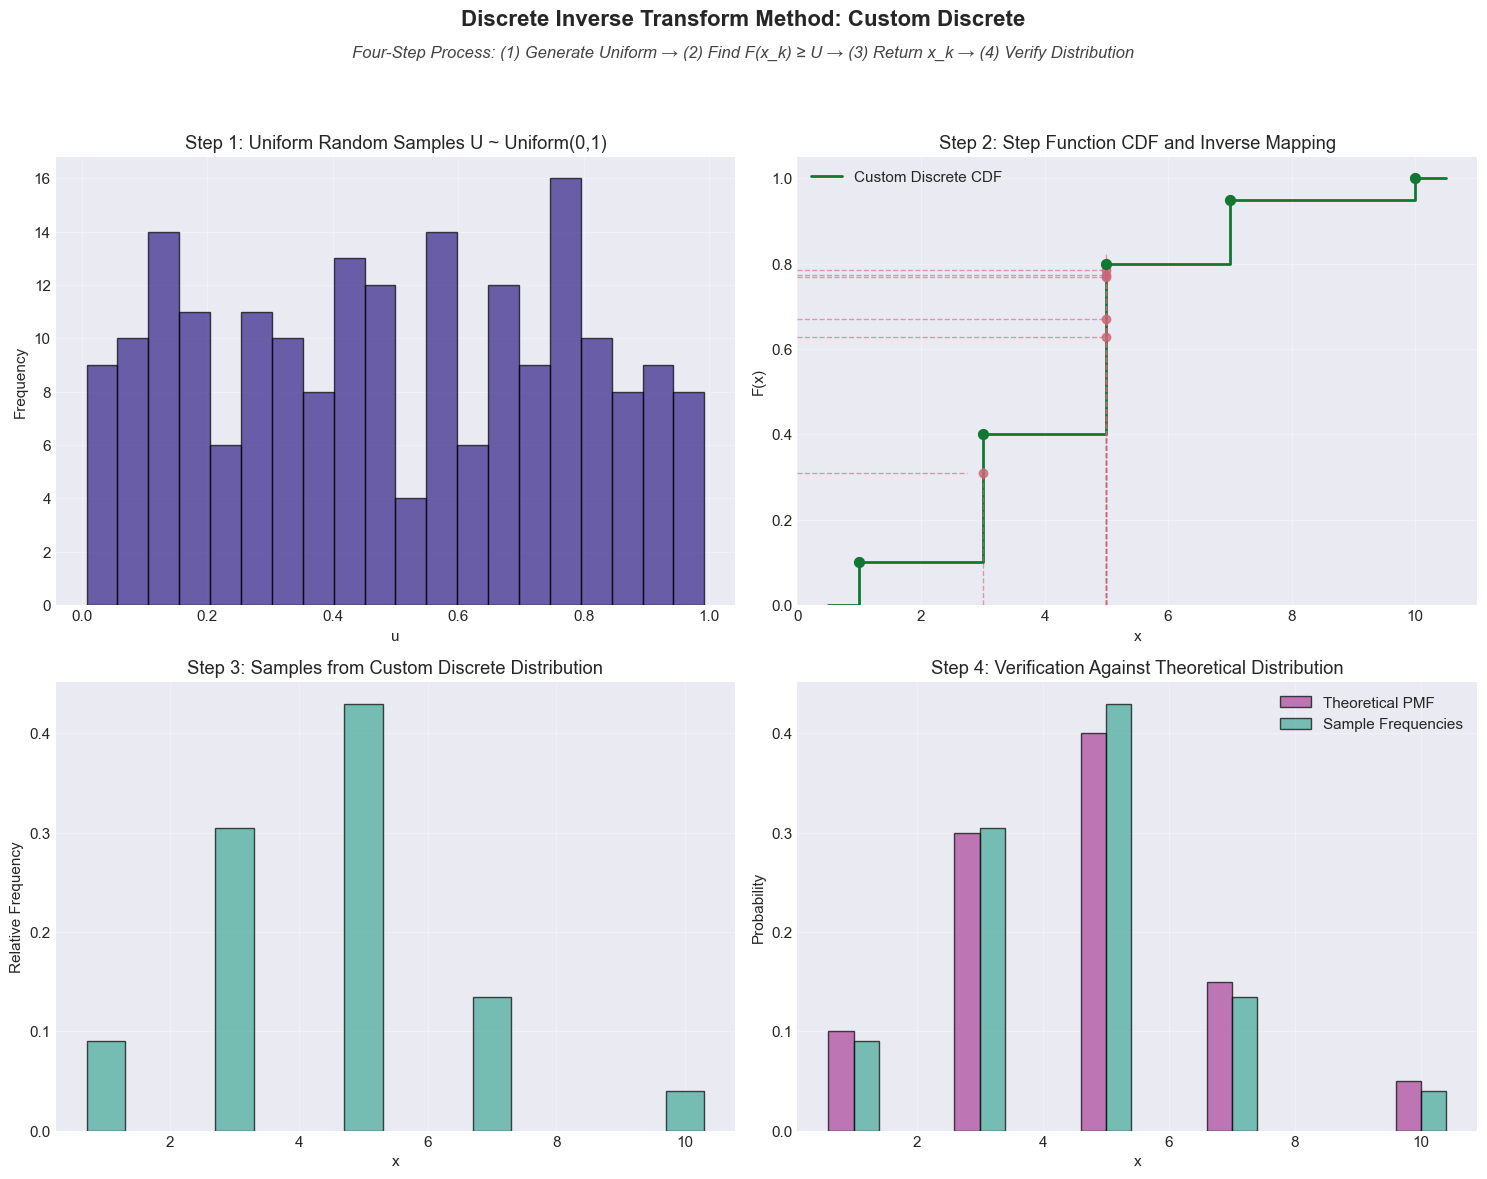

In [72]:
# Define a custom discrete distribution
values_custom = np.array([1, 3, 5, 7, 10])
probabilities_custom = np.array([0.1, 0.3, 0.4, 0.15, 0.05])

print("Custom Discrete Distribution:")
print("Values:", values_custom)
print("Probabilities:", probabilities_custom)
print("Sum of probabilities:", probabilities_custom.sum())

# Visualize the transformation process
sampler_custom = visualize_discrete_inverse_transform(
    values_custom, probabilities_custom, "Custom Discrete", n_samples=200
)

In [73]:
# Analyze the custom distribution samples
n_large = 10000
samples_custom = sampler_custom.sample(n_large)

# Compute theoretical moments
theoretical_mean = np.sum(values_custom * probabilities_custom)
theoretical_var = np.sum(values_custom**2 * probabilities_custom) - theoretical_mean**2
theoretical_std = np.sqrt(theoretical_var)

# Compute sample moments
sample_mean = np.mean(samples_custom)
sample_std = np.std(samples_custom)

print(f"Statistical Analysis ({n_large:,} samples):")
print(f"Theoretical mean: {theoretical_mean:.4f}")
print(f"Sample mean: {sample_mean:.4f}")
print(f"Theoretical std: {theoretical_std:.4f}")
print(f"Sample std: {sample_std:.4f}")

# Check frequency distribution
unique_vals, counts = np.unique(samples_custom, return_counts=True)
observed_probs = counts / n_large

print("\nFrequency Analysis:")
for val, theoretical_prob, observed_prob in zip(
    values_custom, probabilities_custom, observed_probs
):
    print(
        f"  Value {val}: Theoretical {theoretical_prob:.3f}, Observed {observed_prob:.3f}"
    )

Statistical Analysis (10,000 samples):
Theoretical mean: 4.5500
Sample mean: 4.5168
Theoretical std: 2.1089
Sample std: 2.0993

Frequency Analysis:
  Value 1: Theoretical 0.100, Observed 0.103
  Value 3: Theoretical 0.300, Observed 0.303
  Value 5: Theoretical 0.400, Observed 0.398
  Value 7: Theoretical 0.150, Observed 0.149
  Value 10: Theoretical 0.050, Observed 0.047


## 4. Example 2: Geometric Distribution

The geometric distribution models the number of trials until the first success in Bernoulli trials.
It takes values $\{1, 2, 3, \ldots\}$ with probabilities $p(1-p)^{k-1}$ for parameter $p \in (0,1)$.

Geometric Distribution (p=0.3, truncated at 15):
Theoretical mean (untruncated): 3.33
Sum of truncated probabilities: 1.000000


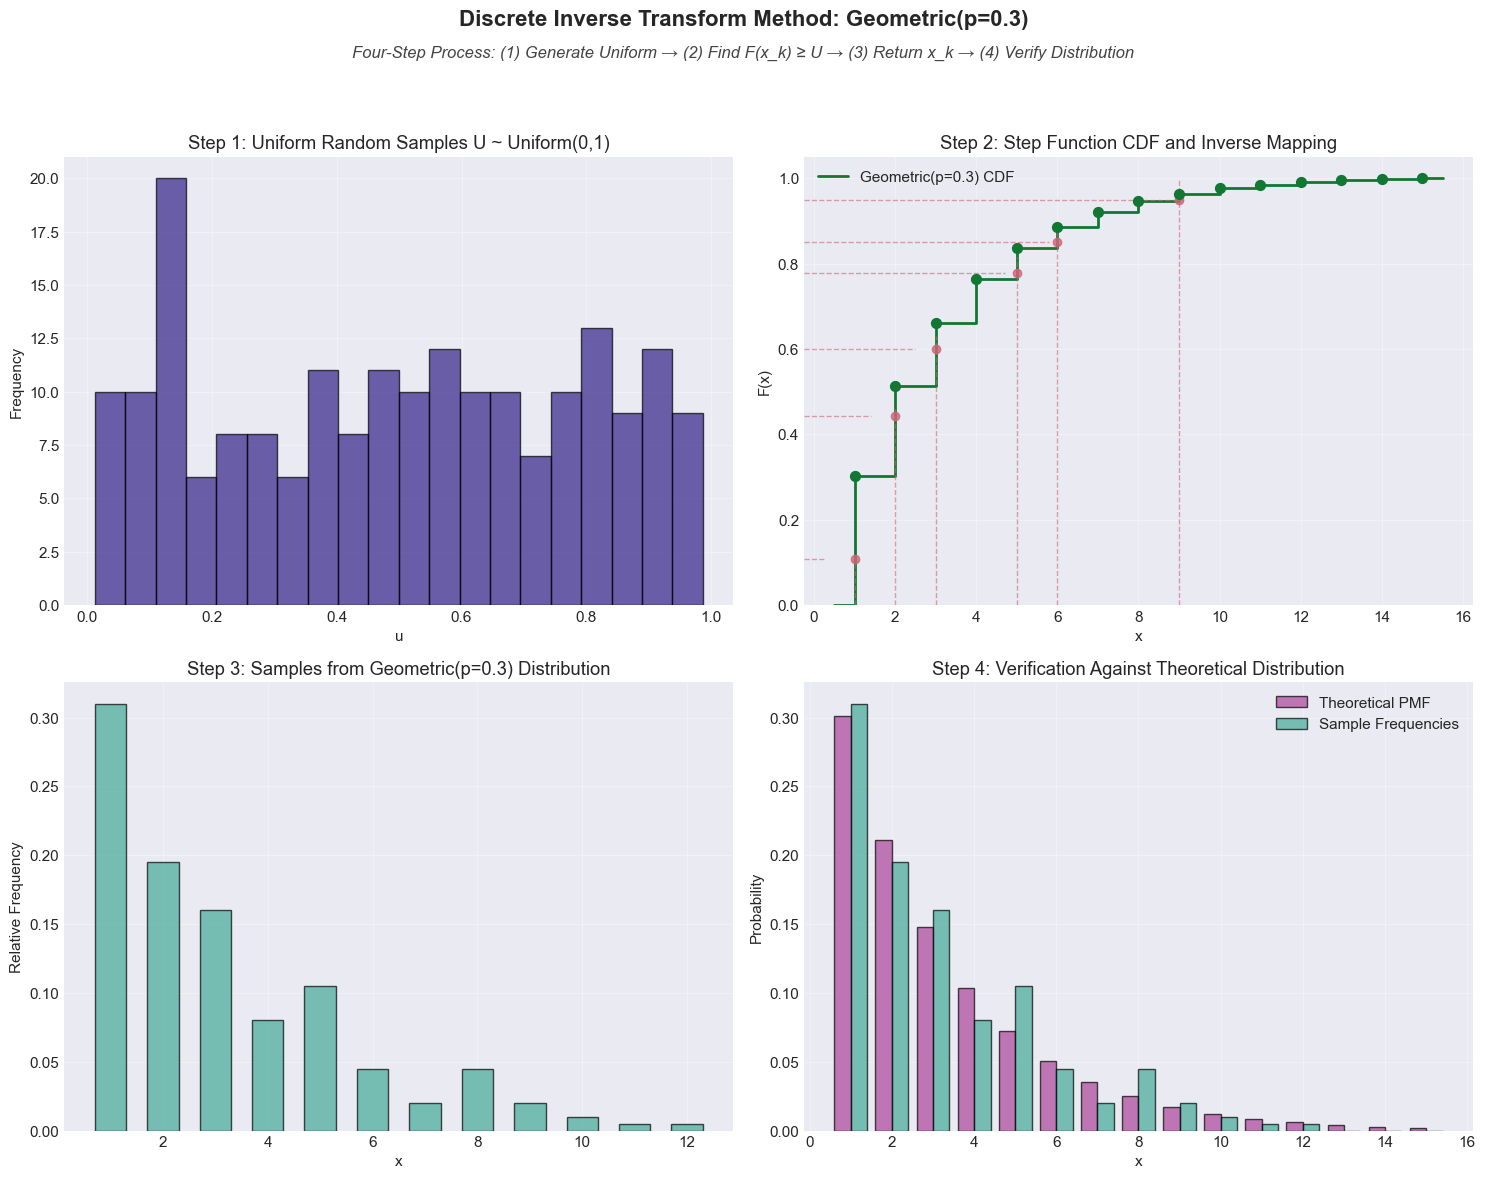

In [74]:
# Geometric distribution parameters
p_success = 0.3
max_trials = 15  # Truncate for practical visualization

# Generate geometric distribution values and probabilities
values_geometric = np.arange(1, max_trials + 1)
probabilities_geometric = p_success * ((1 - p_success) ** (values_geometric - 1))

# Renormalize to account for truncation
probabilities_geometric = probabilities_geometric / probabilities_geometric.sum()

print(f"Geometric Distribution (p={p_success}, truncated at {max_trials}):")
print(f"Theoretical mean (untruncated): {1 / p_success:.2f}")
print(f"Sum of truncated probabilities: {probabilities_geometric.sum():.6f}")

# Visualize the transformation
sampler_geometric = visualize_discrete_inverse_transform(
    values_geometric,
    probabilities_geometric,
    f"Geometric(p={p_success})",
    n_samples=200,
)

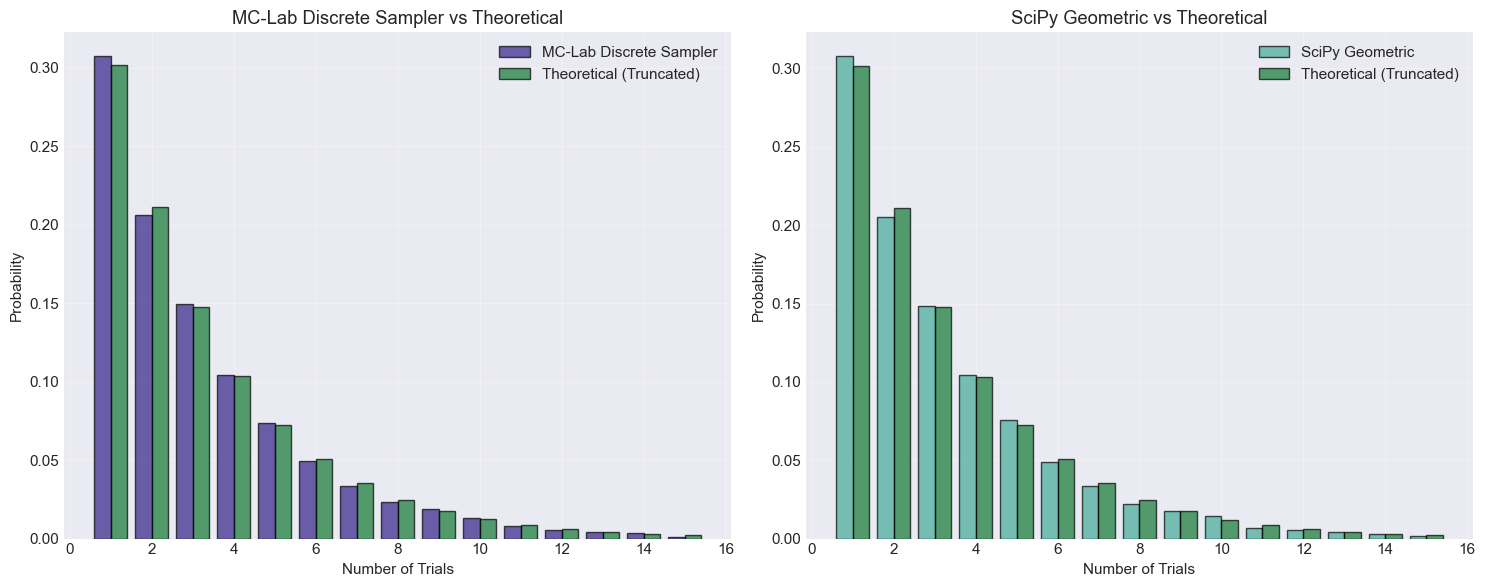

Comparison Results:
MC-Lab sampler mean: 3.236
SciPy sampler mean: 3.237
Theoretical mean (truncated): 3.262


In [75]:
# Compare with SciPy's geometric distribution
n_samples_comparison = 5000

# Our discrete sampler (truncated)
samples_our = sampler_geometric.sample(n_samples_comparison)

# SciPy's geometric distribution (note: different parameterization)
# SciPy uses geometric(p) for number of failures before first success
# We want number of trials until first success, so we add 1
samples_scipy = stats.geom.rvs(
    p_success, size=n_samples_comparison, random_state=RANDOM_SEED
)
samples_scipy = samples_scipy[
    samples_scipy <= max_trials
]  # Truncate for fair comparison

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot our sampler
unique_our, counts_our = np.unique(samples_our, return_counts=True)
freqs_our = counts_our / len(samples_our)
ax1.bar(
    unique_our - 0.2,
    freqs_our,
    width=0.4,
    alpha=0.7,
    color=COLORS[0],
    edgecolor="black",
    label="MC-Lab Discrete Sampler",
)

# Plot theoretical probabilities
ax1.bar(
    values_geometric + 0.2,
    probabilities_geometric,
    width=0.4,
    alpha=0.7,
    color=COLORS[1],
    edgecolor="black",
    label="Theoretical (Truncated)",
)

ax1.set_title("MC-Lab Discrete Sampler vs Theoretical")
ax1.set_xlabel("Number of Trials")
ax1.set_ylabel("Probability")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot SciPy comparison
unique_scipy, counts_scipy = np.unique(samples_scipy, return_counts=True)
freqs_scipy = counts_scipy / len(samples_scipy)
ax2.bar(
    unique_scipy - 0.2,
    freqs_scipy,
    width=0.4,
    alpha=0.7,
    color=COLORS[2],
    edgecolor="black",
    label="SciPy Geometric",
)

ax2.bar(
    values_geometric + 0.2,
    probabilities_geometric,
    width=0.4,
    alpha=0.7,
    color=COLORS[1],
    edgecolor="black",
    label="Theoretical (Truncated)",
)

ax2.set_title("SciPy Geometric vs Theoretical")
ax2.set_xlabel("Number of Trials")
ax2.set_ylabel("Probability")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Comparison Results:")
print(f"MC-Lab sampler mean: {np.mean(samples_our):.3f}")
print(f"SciPy sampler mean: {np.mean(samples_scipy):.3f}")
print(
    f"Theoretical mean (truncated): {np.sum(values_geometric * probabilities_geometric):.3f}"
)

## 5. Example 3: Loaded Die Distribution

A practical example: simulating a loaded six-sided die where some faces are more likely than others.

Loaded Die Distribution:
Face probabilities:
  Face 1: 0.0769 (7.7%)
  Face 2: 0.1538 (15.4%)
  Face 3: 0.1538 (15.4%)
  Face 4: 0.1538 (15.4%)
  Face 5: 0.1538 (15.4%)
  Face 6: 0.3077 (30.8%)
Sum: 1.000000


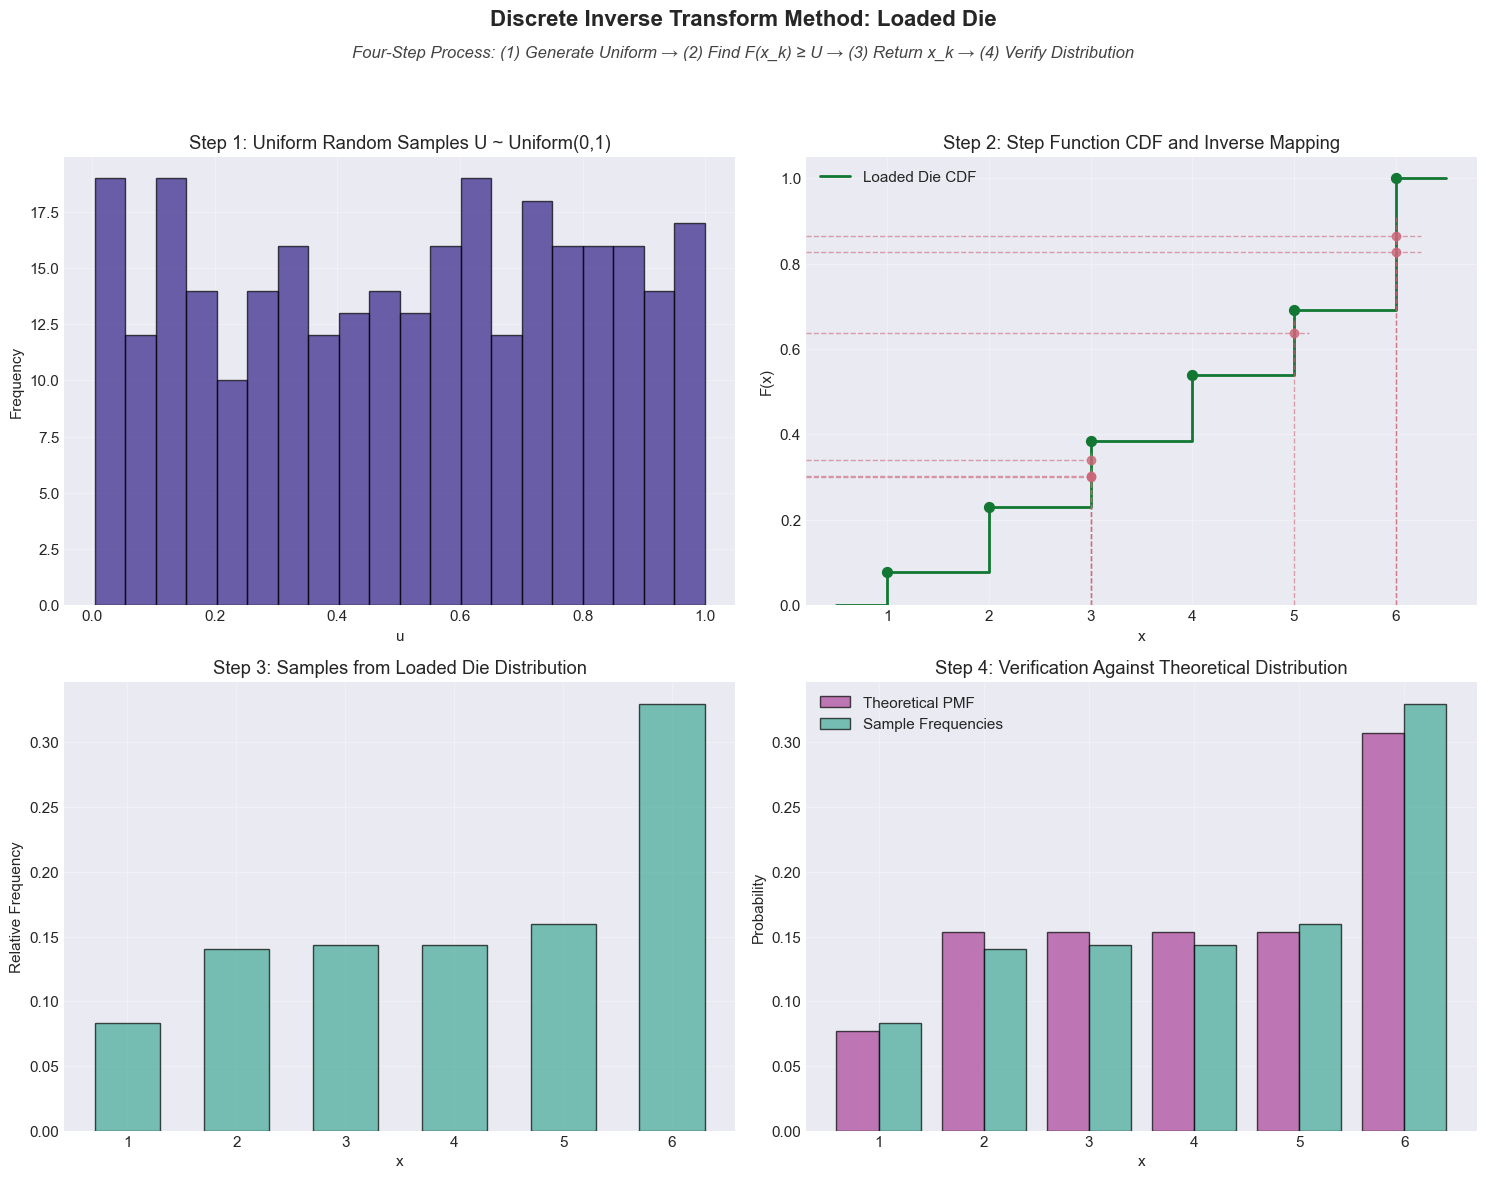

In [76]:
# Loaded die: face 6 is twice as likely, face 1 is half as likely
values_die = np.array([1, 2, 3, 4, 5, 6])

# Let x be base probability for faces 2,3,4,5
# Then: x/2 + 4x + 2x = 1 → 6.5x = 1 → x = 2/13
base_prob = 2 / 13
probabilities_die = np.array(
    [base_prob / 2, base_prob, base_prob, base_prob, base_prob, 2 * base_prob]
)

print("Loaded Die Distribution:")
print("Face probabilities:")
for face, prob in zip(values_die, probabilities_die):
    print(f"  Face {face}: {prob:.4f} ({prob * 100:.1f}%)")
print(f"Sum: {probabilities_die.sum():.6f}")

# Visualize the loaded die
sampler_die = visualize_discrete_inverse_transform(
    values_die, probabilities_die, "Loaded Die", n_samples=300
)

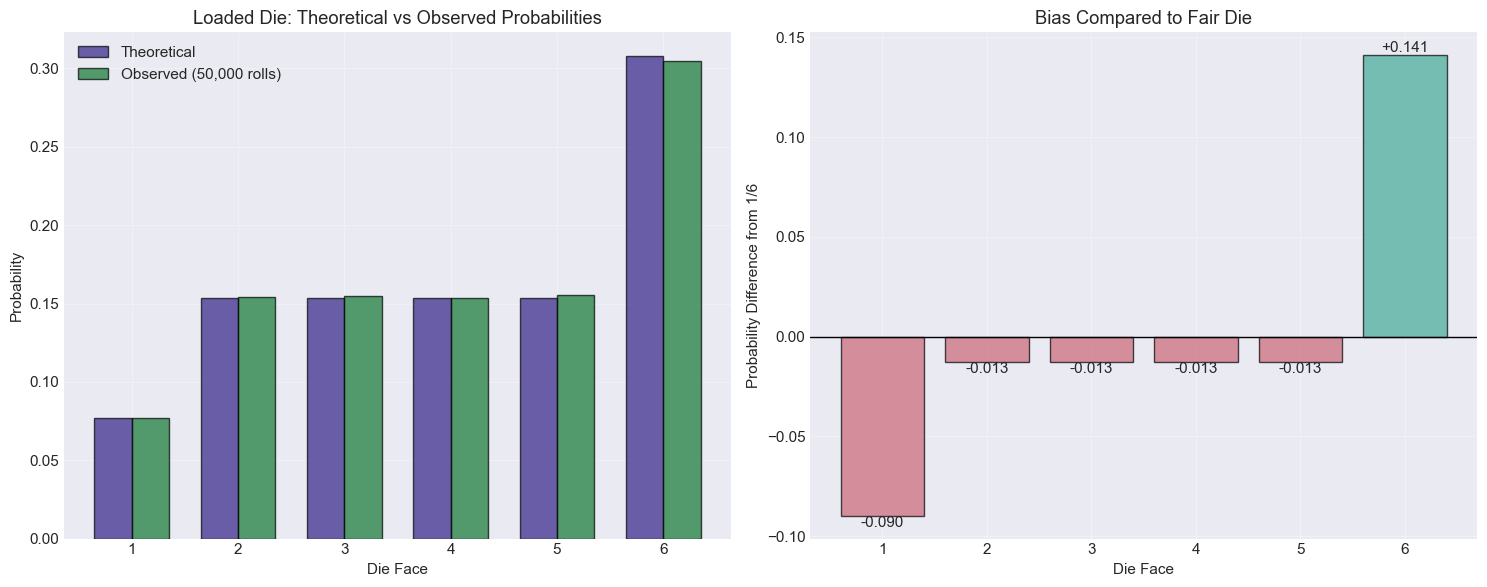

Statistical Analysis:
Number of rolls: 50,000
Expected value: 4.077
Observed mean: 4.071

Detailed Comparison:
  Face 1: Expected 0.0769, Observed 0.0770, Diff +0.0001
  Face 2: Expected 0.1538, Observed 0.1542, Diff +0.0003
  Face 3: Expected 0.1538, Observed 0.1549, Diff +0.0011
  Face 4: Expected 0.1538, Observed 0.1538, Diff -0.0001
  Face 5: Expected 0.1538, Observed 0.1552, Diff +0.0014
  Face 6: Expected 0.3077, Observed 0.3049, Diff -0.0028

Goodness of Fit Test:
Chi-square statistic: 2.3009
Degrees of freedom: 5
p-value: 0.8061
Result: PASS (p > 0.05 indicates good fit)


In [77]:
# Simulate many dice rolls and analyze bias
n_rolls = 50000
die_rolls = sampler_die.sample(n_rolls)

# Count occurrences
unique_faces, counts = np.unique(die_rolls, return_counts=True)
observed_probs = counts / n_rolls

# Create detailed comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot comparison
x = np.arange(len(values_die))
width = 0.35

ax1.bar(
    x - width / 2,
    probabilities_die,
    width,
    alpha=0.7,
    color=COLORS[0],
    label="Theoretical",
    edgecolor="black",
)
ax1.bar(
    x + width / 2,
    observed_probs,
    width,
    alpha=0.7,
    color=COLORS[1],
    label=f"Observed ({n_rolls:,} rolls)",
    edgecolor="black",
)

ax1.set_title("Loaded Die: Theoretical vs Observed Probabilities")
ax1.set_xlabel("Die Face")
ax1.set_ylabel("Probability")
ax1.set_xticks(x)
ax1.set_xticklabels(values_die)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bias analysis: difference from fair die
fair_prob = 1 / 6
bias = probabilities_die - fair_prob

colors = [COLORS[2] if b >= 0 else COLORS[5] for b in bias]
ax2.bar(values_die, bias, alpha=0.7, color=colors, edgecolor="black")
ax2.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax2.set_title("Bias Compared to Fair Die")
ax2.set_xlabel("Die Face")
ax2.set_ylabel("Probability Difference from 1/6")
ax2.grid(True, alpha=0.3)

# Add text annotations for bias
for face, b in zip(values_die, bias):
    if b != 0:
        ax2.annotate(
            f"{b:+.3f}", (face, b), ha="center", va="bottom" if b > 0 else "top"
        )

plt.tight_layout()
plt.show()

# Statistical summary
print("Statistical Analysis:")
print(f"Number of rolls: {n_rolls:,}")
print(f"Expected value: {np.sum(values_die * probabilities_die):.3f}")
print(f"Observed mean: {np.mean(die_rolls):.3f}")

print("\nDetailed Comparison:")
for face, theoretical, observed in zip(values_die, probabilities_die, observed_probs):
    diff = observed - theoretical
    print(
        f"  Face {face}: Expected {theoretical:.4f}, Observed {observed:.4f}, Diff {diff:+.4f}"
    )

# Chi-square goodness of fit test
expected_counts = probabilities_die * n_rolls
chi2_stat = np.sum((counts - expected_counts) ** 2 / expected_counts)
degrees_freedom = len(values_die) - 1
p_value = 1 - stats.chi2.cdf(chi2_stat, degrees_freedom)

print("\nGoodness of Fit Test:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {degrees_freedom}")
print(f"p-value: {p_value:.4f}")
print(f"Result: {'PASS' if p_value > 0.05 else 'FAIL'} (p > 0.05 indicates good fit)")

## 6. Performance Analysis and Method Comparison

In [ ]:
import time


def compare_discrete_sampling_methods():
    """Compare different approaches to discrete sampling."""

    # Use the loaded die as test case
    n_samples = 100000
    n_trials = 5

    # Method 1: MC-Lab DiscreteInverseTransformSampler
    def method_mc_lab():
        sampler = DiscreteInverseTransformSampler(
            values_die, probabilities_die, random_state=42
        )
        return sampler.sample(n_samples)

    # Method 2: MC-Lab factory function
    def method_factory():
        sampler = create_sampler(
            values=values_die,
            probabilities=probabilities_die,
            method="discrete",
            random_state=42,
        )
        return sampler.sample(n_samples)

    # Method 3: NumPy choice (for comparison)
    def method_numpy_choice():
        rng_local = np.random.default_rng(42)
        return rng_local.choice(values_die, size=n_samples, p=probabilities_die)

    # Method 4: Manual inverse transform
    def method_manual():
        rng_local = np.random.default_rng(42)
        u = rng_local.uniform(0, 1, n_samples)
        cumulative = np.cumsum(probabilities_die)
        indices = np.searchsorted(cumulative, u, side="right")
        indices = np.clip(indices, 0, len(values_die) - 1)
        return values_die[indices]

    methods_list = [
        ("MC-Lab Discrete Sampler", method_mc_lab),
        ("MC-Lab Factory Function", method_factory),
        ("NumPy Choice", method_numpy_choice),
        ("Manual Implementation", method_manual),
    ]

    results = []

    for method_name, method_func in methods_list:
        print(f"Testing {method_name}...")

        times = []
        for trial in range(n_trials):
            start_time = time.time()
            samples = method_func()
            end_time = time.time()
            times.append(end_time - start_time)

        avg_time = np.mean(times)
        std_time = np.std(times)
        samples_per_sec = n_samples / avg_time

        # Check correctness
        sample_mean = np.mean(samples)
        expected_mean = np.sum(values_die * probabilities_die)

        results.append(
            {
                "Method": method_name,
                "Avg Time (s)": f"{avg_time:.4f} ± {std_time:.4f}",
                "Samples/sec": f"{samples_per_sec:,.0f}",
                "Sample Mean": f"{sample_mean:.4f}",
                "Expected Mean": f"{expected_mean:.4f}",
                "Error": f"{abs(sample_mean - expected_mean):.4f}",
            }
        )

    # Create results table
    df = pd.DataFrame(results)
    print(f"\nPerformance Comparison ({n_samples:,} samples, {n_trials} trials each):")
    print("=" * 100)
    print(df.to_string(index=False))
    print("=" * 100)

    return results


performance_results = compare_discrete_sampling_methods()

Testing MC-Lab Discrete Sampler...
Testing MC-Lab Factory Function...
Testing NumPy Choice...
Testing Manual Implementation...

Performance Comparison (100,000 samples, 5 trials each):
                 Method    Avg Time (s) Samples/sec Sample Mean Expected Mean  Error
MC-Lab Discrete Sampler 0.0019 ± 0.0004  51,949,565      4.0753        4.0769 0.0016
MC-Lab Factory Function 0.0016 ± 0.0001  63,498,108      4.0753        4.0769 0.0016
           NumPy Choice 0.0019 ± 0.0002  52,175,748      4.0814        4.0769 0.0045
  Manual Implementation 0.0015 ± 0.0001  64,609,261      4.0814        4.0769 0.0045


## 7. Factory Function Usage Examples

In [79]:
# Demonstrate the factory function for creating discrete samplers
print("Factory Function Examples:")
print("=" * 50)

# Example 1: Simple coin flip (biased)
coin_values = np.array([0, 1])  # 0 = Tails, 1 = Heads
coin_probs = np.array([0.3, 0.7])  # Biased towards heads

coin_sampler = create_sampler(
    values=coin_values,
    probabilities=coin_probs,
    method="discrete",
    random_state=RANDOM_SEED,
)

coin_flips = coin_sampler.sample(1000)
heads_rate = np.mean(coin_flips)
print("1. Biased Coin (P(Heads)=0.7):")
print(f"   Observed heads rate: {heads_rate:.3f}")
print("   Expected heads rate: 0.700")

# Example 2: Poisson-like distribution (truncated)
lambda_param = 2.5
max_k = 10

poisson_values = np.arange(0, max_k + 1)
poisson_probs = np.array(
    [
        np.exp(-lambda_param) * (lambda_param**k) / math.factorial(k)
        for k in poisson_values
    ]
)
poisson_probs = poisson_probs / poisson_probs.sum()  # Renormalize

poisson_sampler = create_sampler(
    values=poisson_values,
    probabilities=poisson_probs,
    method="discrete",
    random_state=RANDOM_SEED,
)

poisson_samples = poisson_sampler.sample(5000)
sample_mean = np.mean(poisson_samples)
theoretical_mean = np.sum(poisson_values * poisson_probs)

print(f"\n2. Truncated Poisson (λ={lambda_param}, k≤{max_k}):")
print(f"   Sample mean: {sample_mean:.3f}")
print(f"   Theoretical mean: {theoretical_mean:.3f}")

# Example 3: Custom distribution with quantile sampling
print("\n3. Quantile Sampling Example:")

# Use the loaded die sampler for quantile demonstration
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_samples = sampler_die.sample_quantiles(quantiles)

print("   Quantile samples from loaded die:")
for q, sample in zip(quantiles, quantile_samples):
    print(f"   {q * 100:3.0f}th percentile: {sample}")

# Show the CDF structure
cumulative = np.cumsum(probabilities_die)
print(f"\n   CDF values: {cumulative}")
print("   This explains why certain quantiles map to the same value!")

Factory Function Examples:
1. Biased Coin (P(Heads)=0.7):
   Observed heads rate: 0.681
   Expected heads rate: 0.700

2. Truncated Poisson (λ=2.5, k≤10):
   Sample mean: 2.480
   Theoretical mean: 2.499

3. Quantile Sampling Example:
   Quantile samples from loaded die:
    10th percentile: 2
    25th percentile: 3
    50th percentile: 4
    75th percentile: 6
    90th percentile: 6

   CDF values: [0.07692308 0.23076923 0.38461538 0.53846154 0.69230769 1.        ]
   This explains why certain quantiles map to the same value!


## Summary and Key Takeaways

This notebook has demonstrated the discrete inverse transform method through theory and practical examples:

### Key Theoretical Insights
1. **Algorithm 2.3**: Find the smallest $k$ such that $F(x_k) \geq U$ for discrete distributions
2. **Step Function CDFs**: Discrete distributions have jump discontinuities at each possible value
3. **Generalized Inverse**: $F^{-1}(u) = \min\{x : F(x) \geq u\}$ handles step functions correctly
4. **Efficient Implementation**: `np.searchsorted()` provides O(log n) lookup time

### Practical Applications Demonstrated
1. **Custom Distributions**: Easy to specify arbitrary discrete distributions
2. **Standard Distributions**: Can implement truncated versions of well-known distributions
3. **Real-world Examples**: Loaded dice, biased coins, and other practical scenarios
4. **Quantile Sampling**: Direct access to specific percentiles of the distribution

### Implementation Advantages
- **Exact Sampling**: No approximation errors unlike some other methods
- **Computational Efficiency**: Competitive with NumPy's optimized functions
- **Flexibility**: Works with any discrete distribution
- **Integration**: Seamlessly fits into the MC-Lab framework
- **Reproducibility**: Deterministic transformation from uniform inputs

### Performance Characteristics
- Setup time is minimal (just sorting values and computing cumulative probabilities)
- Sampling time scales as O(log n) where n is the number of possible values
- Memory usage is proportional to the number of distinct values
- Competitive performance with specialized library functions

The discrete inverse transform method complements the continuous version, providing a complete toolkit for inverse transform sampling across all types of distributions.